## Deep Neural Networks


To tackle a complex problem, such as detecting hundreds of types of objects in high-resolution images? You may need to train a much deeper DNN, perhaps with 10 layers or many more, each containing hundreds of neurons, linked by hundreds of thousands of connections.

 - Vanishing gradients/Exploding gradients
 - Reusing pretrained layers
 - Faster optimizer
 - Avoiding overfitting through regularization
 


### Setup

Importing common modules. Using the Python3 as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
RESOURCE_DIR = os.path.join(PROJECT_ROOT_DIR, "resource")

def save_fig(fig, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(RESOURCE_DIR, fig + "." + fig_extension)
    print("Saving figure...", fig)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2023-04-03 15:34:46.913571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 15:34:48.678436: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/cuda/include
2023-04-03 15:34:48.678508: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPT



### Vanishing/Exploding gradients problem


In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure... sigmoid_saturation_plot


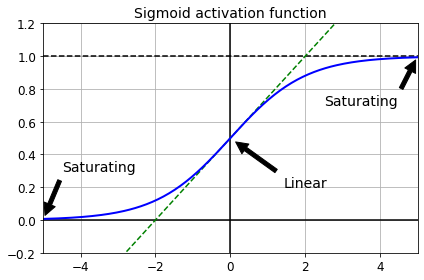

In [3]:
# This is when the gradients grow smaller and smaller, or larger and larger, 
# when flowing backward through  the DNN during training. Both of these problems 
# make lower layers very hard to train.
# The backpropagation algorithm works by going from the output layer to the input layer, 
# propagating the error gradient along the way. Once the algorithm has computed 
# the gradient of the cost function with regard to each parameter in the network, 
# it uses these gradients to update each parameter with a Gradient Descent step.
# Unfortunately, gradients often get smaller and smaller as the algorithm progresses 
# down to the lower layers. As a result, the Gradient Descent update leaves the lower 
# layers’ connection weights virtually unchanged, and training never converges to a 
# good solution. This the vanishing gradients problem.
#
# In some cases, the opposite can happen: the gradients can grow bigger and bigger 
# until layers get insanely large weight updates and the algorithm diverges. 
# This is the exploding gradients problem,

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()



#### Glorot and He Initialization

In [4]:
# Glorot and Bengio propose a way to significantly alleviate
# the unstable gradients problem. They point out that we need the signal to
# flow properly in both directions: in the forward direction when making
# predictions, and in the reverse direction when backpropagating gradients.
# We don’t want the signal to die out, nor do we want it to explode and
# saturate. For the signal to flow properly, the authors argue that we need the
# variance of the outputs of each layer to be equal to the variance of its
# inputs, and we need the gradients to have equal variance before and after
# flowing through a layer in the reverse direction.

[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
# Initialization    Activation functions                    σ² (Normal)
# --------------    --------------------                   -------------   
# Glorot            None, tanh, logistic, softmax            1/fan_avg
# He                ReLU and variants                        2/fan_in
# LeCun             SELU                                     1/fan_in
#
# The initialization strategy for the ReLU activation function (and its variants, 
# including the ELU activation described shortly) is sometimes called 
# He initialization. By default, Keras uses Glorot initialization with a 
# uniform distribution. When creating a layer, you can change this to He initialization

keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
# If you want He initialization with a uniform distribution but based on
# fan avg rather than fan in , you can use the VarianceScaling initializer.


init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)



#### Nonsaturating Activation Functions


##### Leaky ReLU

In [7]:
# ReLU activation function behaves much better in in DNN, mostly because it does not
# saturate for positive values (and because it is fast to compute).
#
# Unfortunately, the ReLU activation function is not perfect. It suffers from
# a problem known as the dying ReLUs: during training, some neurons effectively “die,” 
# meaning they stop outputting anything other than 0. In some cases, you may find that 
# half of your network’s neurons are dead, especially if you used a large learning rate. 
# A neuron dies when its weights get tweaked in such a way that the weighted sum of 
# its inputs are negative for all instances in the training set. When this happens, 
# it just keeps outputting zeros, and Gradient Descent does not affect it anymore because
# the gradient of the ReLU function is zero when its input is negative.
#
# To solve this problem, you may want to use a variant of the ReLU function, such as 
# the leaky ReLU. This function is defined as LeakyReLU α (z) = max(αz, z). 
# The hyperparameter α defines how much the function “leaks”: it is the slope of the 
# function for z < 0 and is typically set to 0.01. This small slope ensures that 
# leaky ReLUs never die; they can go into a long coma, but they have a chance to
# eventually wake up.


def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure... leaky_relu_plot


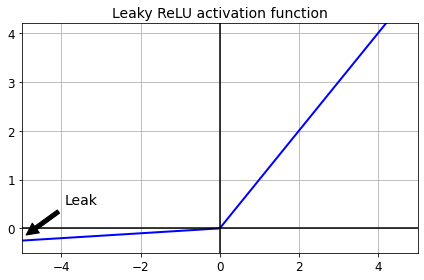

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [11]:
# Let's train a neural network on Fashion MNIST using the Leaky ReLU:

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

2023-04-03 15:34:54.832043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 15:34:54.874673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 15:34:54.875401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 15:34:54.877178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10


2023-04-03 15:34:56.085153: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.
2023-04-03 15:34:56.189179: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.
2023-04-03 15:34:57.398526: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1e1a9970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-03 15:34:57.398546: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 3000, Compute Capability 7.5
2023-04-03 15:34:57.708614: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 [==============================] - 5s 2ms/step - loss: 1.2374 - accuracy: 0.6057 - val_loss: 0.8594 - val_accuracy: 0.7156
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7866 - accuracy: 0.7395 - val_loss: 0.7038 - val_accuracy: 0.7662
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6819 - accuracy: 0.7726 - val_loss: 0.6407 - val_accuracy: 0.7906
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6240 - accuracy: 0.7923 - val_loss: 0.5864 - val_accuracy: 0.8072
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5858 - accuracy: 0.8051 - val_loss: 0.5544 - val_accuracy: 0.8196
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5580 - accuracy: 0.8126 - val_loss: 0.5315 - val_accuracy: 0.8266
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5370 - accuracy: 0.8189 - val_loss: 0.5122 - val_accuracy: 0.8338
Epo

In [15]:
# Now let's try PReLU:
# The parametric leaky ReLU (PReLU), where α is authorized to be learned during 
# training (instead ofbeing a hyperparameter, it becomes a parameter that can 
# be modified by backpropagation like any other parameter). PReLU was reported to
# strongly outperform ReLU on large image datasets, but on smaller datasets
# it runs the risk of overfitting the training set.


tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10


2023-04-03 15:35:29.868033: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.
2023-04-03 15:35:29.962836: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.


1719/1719 [==============================] - 5s 3ms/step - loss: 1.3085 - accuracy: 0.6126 - val_loss: 0.8881 - val_accuracy: 0.7242
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7939 - accuracy: 0.7501 - val_loss: 0.7077 - val_accuracy: 0.7756
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6768 - accuracy: 0.7848 - val_loss: 0.6394 - val_accuracy: 0.7966
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6161 - accuracy: 0.8014 - val_loss: 0.5835 - val_accuracy: 0.8160
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5771 - accuracy: 0.8134 - val_loss: 0.5518 - val_accuracy: 0.8232
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5491 - accuracy: 0.8202 - val_loss: 0.5281 - val_accuracy: 0.8334
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5280 - accuracy: 0.8251 - val_loss: 0.5089 - val_accuracy: 0.8376
Epo



##### ELU


In [18]:
# the exponential linear unit (ELU) that outperformed all the ReLU variants 
# in the authors’ experiments: training time was reduced, and the neural network performed 
# better on the test set.
#
# It takes on negative values when z < 0, which allows the unit to have an average 
# output closer to 0 and helps alleviate the vanishing gradients problem.
# 
# It has a nonzero gradient for z < 0, which avoids the dead neurons problem.
# 
# If α is equal to 1 then the function is smooth everywhere, including around z = 0, 
# which helps speed up Gradient Descent since it does not bounce as much to the 
# left and right of z = 0.



def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure... elu_plot


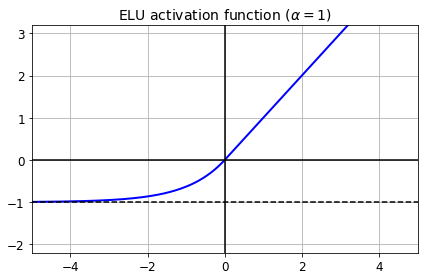

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

In [20]:
# Implementing ELU in TensorFlow is trivial, just specify the activation function 
# when building each layer:


keras.layers.Dense(10, activation="elu")



##### SELU


During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [21]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure... selu_plot


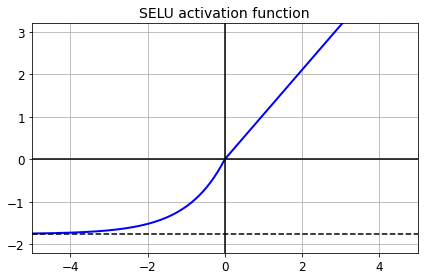

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [24]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [25]:
# Using SELU is easy.

keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

In [26]:
# Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU 
# activation function.


np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [29]:
# Now let's train it. Do not forget to scale the inputs to mean 0 and 
# standard deviation 1.
# Calculate the Z-Score distributions

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [30]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5


2023-04-03 15:36:15.706296: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.


1719/1719 [==============================] - 32s 15ms/step - loss: 1.1771 - accuracy: 0.5487 - val_loss: 0.7549 - val_accuracy: 0.7072
Epoch 2/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.7121 - accuracy: 0.7187 - val_loss: 0.6097 - val_accuracy: 0.7692
Epoch 3/5
1719/1719 [==============================] - 25s 14ms/step - loss: 0.5902 - accuracy: 0.7802 - val_loss: 0.6558 - val_accuracy: 0.7724
Epoch 4/5
1719/1719 [==============================] - 25s 15ms/step - loss: 0.5380 - accuracy: 0.8123 - val_loss: 0.5965 - val_accuracy: 0.7946
Epoch 5/5
1719/1719 [==============================] - 25s 15ms/step - loss: 0.4824 - accuracy: 0.8313 - val_loss: 0.4722 - val_accuracy: 0.8380


In [31]:
# Now look at what happens if we try to use the ReLU activation function instead.

np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [34]:
# Not great at all, we suffered from the vanishing/exploding gradients problem.


history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 32s 15ms/step - loss: 2.0374 - accuracy: 0.2107 - val_loss: 1.7688 - val_accuracy: 0.3132
Epoch 2/5
1719/1719 [==============================] - 25s 15ms/step - loss: 1.7356 - accuracy: 0.3175 - val_loss: 1.5665 - val_accuracy: 0.4028
Epoch 3/5
1719/1719 [==============================] - 25s 15ms/step - loss: 1.4033 - accuracy: 0.4090 - val_loss: 1.2993 - val_accuracy: 0.4312
Epoch 4/5
1719/1719 [==============================] - 25s 15ms/step - loss: 1.1541 - accuracy: 0.5037 - val_loss: 1.0275 - val_accuracy: 0.5624
Epoch 5/5
1719/1719 [==============================] - 25s 14ms/step - loss: 0.9768 - accuracy: 0.5784 - val_loss: 0.8674 - val_accuracy: 0.6316




#### Batch Normalization




Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.

The Batch Normalization (BN) that addresses these problems. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs.

In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set (e.g., using a StandardScaler ); the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and standard deviation of the input over the current mini-batch (hence the name “Batch Normalization”).


In [35]:

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_212 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_213 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

In [37]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [38]:
#bn1.updates #deprecated

In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 0.8721 - accuracy: 0.7056 - val_loss: 0.5748 - val_accuracy: 0.8100
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5876 - accuracy: 0.7978 - val_loss: 0.4925 - val_accuracy: 0.8350
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5271 - accuracy: 0.8171 - val_loss: 0.4541 - val_accuracy: 0.8444
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4878 - accuracy: 0.8288 - val_loss: 0.4315 - val_accuracy: 0.8548
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4605 - accuracy: 0.8383 - val_loss: 0.4130 - val_accuracy: 0.8592
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4421 - accuracy: 0.8440 - val_loss: 0.4007 - val_accuracy: 0.8636
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4284 - accuracy: 0.8489 - val_loss: 0.3904 - val_accuracy:



Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer has some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers


In [41]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [42]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [43]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 1.0340 - accuracy: 0.6821 - val_loss: 0.6874 - val_accuracy: 0.7882
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6785 - accuracy: 0.7843 - val_loss: 0.5608 - val_accuracy: 0.8200
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5960 - accuracy: 0.8040 - val_loss: 0.5055 - val_accuracy: 0.8360
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5435 - accuracy: 0.8193 - val_loss: 0.4703 - val_accuracy: 0.8428
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5122 - accuracy: 0.8261 - val_loss: 0.4472 - val_accuracy: 0.8494
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4889 - accuracy: 0.8329 - val_loss: 0.4292 - val_accuracy: 0.8536
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4720 - accuracy: 0.8399 - val_loss: 0.4157 - val_accuracy:



##### Gradient Clipping




Another popular technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold. This is called Gradient Clipping.

This technique is most often used in recurrent neural networks, as Batch Normalization is tricky to use in RNNs. For other types of networks,
BN is usually sufficient.

In Keras, implementing Gradient Clipping is just a matter of setting the `clipvalue` or `clipnorm` argument when creating an optimizer.


In [44]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [45]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)



### Reusing Pretrained Layers


### Reusing a Keras model

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle, then reuse the lower layers of this network. This technique is called `transfer learning`. It will not only speed up training considerably, but also require significantly less training data.

_If the input pictures of your new task don’t have the same size as the ones used in
_the original task, you will usually have to add a preprocessing step to resize them to
_the size expected by the original model. More generally, transfer learning will work
best when the inputs have similar low-level features._
_The more similar the tasks are, the more layers you want to reuse (starting with the
lower layers). For very similar tasks, try keeping all the hidden layers and just
replacing the output layer._


Let's split the fashion MNIST training set in two:S
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [46]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [47]:
X_train_A.shape

(43986, 28, 28)

In [48]:
X_train_B.shape

(200, 28, 28)

In [49]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [50]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [51]:
tf.random.set_seed(42)
np.random.seed(42)

In [52]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [53]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [54]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.5930 - accuracy: 0.8051 - val_loss: 0.3966 - val_accuracy: 0.8602
Epoch 2/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3624 - accuracy: 0.8738 - val_loss: 0.3325 - val_accuracy: 0.8866
Epoch 3/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.3219 - accuracy: 0.8864 - val_loss: 0.3025 - val_accuracy: 0.9011
Epoch 4/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3015 - accuracy: 0.8954 - val_loss: 0.2888 - val_accuracy: 0.9031
Epoch 5/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2878 - accuracy: 0.9001 - val_loss: 0.2769 - val_accuracy: 0.9098
Epoch 6/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2779 - accuracy: 0.9047 - val_loss: 0.2710 - val_accuracy: 0.9098
Epoch 7/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2698 - accuracy: 0.9073 - val_loss: 0.2705 - val_accuracy:

In [55]:
model_A.save("trained_models/keras_saved_model_A.h5")

In [56]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [57]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [58]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 29ms/step - loss: 0.7942 - accuracy: 0.4800 - val_loss: 0.6367 - val_accuracy: 0.6359
Epoch 2/20
7/7 [==============================] - 0s 13ms/step - loss: 0.5538 - accuracy: 0.7200 - val_loss: 0.4750 - val_accuracy: 0.8114
Epoch 3/20
7/7 [==============================] - 0s 11ms/step - loss: 0.4106 - accuracy: 0.8700 - val_loss: 0.3796 - val_accuracy: 0.8834
Epoch 4/20
7/7 [==============================] - 0s 12ms/step - loss: 0.3268 - accuracy: 0.9200 - val_loss: 0.3153 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 12ms/step - loss: 0.2691 - accuracy: 0.9300 - val_loss: 0.2686 - val_accuracy: 0.9432
Epoch 6/20
7/7 [==============================] - 0s 11ms/step - loss: 0.2260 - accuracy: 0.9750 - val_loss: 0.2375 - val_accuracy: 0.9483
Epoch 7/20
7/7 [==============================] - 0s 11ms/step - loss: 0.1977 - accuracy: 0.9750 - val_loss: 0.2152 - val_accuracy: 0.9513
Epoch 8/20
7/7 [===========

In [59]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_224 (Dense)           (None, 300)               235500    
                                                                 
 dense_225 (Dense)           (None, 100)               30100     
                                                                 
 dense_226 (Dense)           (None, 50)                5050      
                                                                 
 dense_227 (Dense)           (None, 50)                2550      
                                                                 
 dense_228 (Dense)           (None, 50)                2550      
                                                                 
 dense_229 (Dense)           (None, 1)                

In [60]:
model_A = keras.models.load_model("trained_models/keras_saved_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`.

In [61]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [62]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [63]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 28ms/step - loss: 2.4366 - accuracy: 0.3950 - val_loss: 2.3184 - val_accuracy: 0.4016
Epoch 2/4
7/7 [==============================] - 0s 11ms/step - loss: 2.2580 - accuracy: 0.4200 - val_loss: 2.1589 - val_accuracy: 0.4189
Epoch 3/4
7/7 [==============================] - 0s 11ms/step - loss: 2.0971 - accuracy: 0.4500 - val_loss: 2.0056 - val_accuracy: 0.4473
Epoch 4/4
7/7 [==============================] - 0s 11ms/step - loss: 1.9426 - accuracy: 0.4650 - val_loss: 1.8591 - val_accuracy: 0.4604
Epoch 1/16
7/7 [==============================] - 1s 30ms/step - loss: 1.2804 - accuracy: 0.5500 - val_loss: 0.6702 - val_accuracy: 0.6389
Epoch 2/16
7/7 [==============================] - 0s 13ms/step - loss: 0.5070 - accuracy: 0.7500 - val_loss: 0.4378 - val_accuracy: 0.8134
Epoch 3/16
7/7 [==============================] - 0s 12ms/step - loss: 0.3345 - accuracy: 0.8550 - val_loss: 0.3300 - val_accuracy: 0.8773
Epoch 4/16
7/7 [===============

In [64]:
# So, what's the final verdict?

model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0983 - accuracy: 0.9790


[0.09830186516046524, 0.9789999723434448]

In [65]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.1007 - accuracy: 0.9700


[0.10068242996931076, 0.9700000286102295]

Great! We got quite a bit of transfer: the error rate dropped by a factor of 4.9!

In [66]:
(100 - 97.05) / (100 - 99.40)

4.916666666666718



#### Unsupervised Pretraining


Suppose you want to tackle a complex task for which you don’t have much labeled training data, but unfortunately you cannot find a model trained on a similar task. You should try to gather more labeled training data, but if you can’t, you may still be able to perform unsupervised pretraining. 

Indeed, it is often cheap to gather unlabeled training examples, but expensive to label them. If youcan gather plenty of unlabeled training data, you can try to use it to train an unsupervised model, such as an autoencoder or a generative adversarial network.Then you can reuse the lower layers of the autoencoder or the lower layers of the GAN’s discriminator, add the output layer for your task on top, and fine-tune the final network using supervised learning (i.e., with the labeled training examples).



### Faster Optimizers



Training a very large deep neural network can be painfully slow. So far we have seen four ways to speed up training (and reach a better solution):

- **Applying a good initialization strategy for the connection weights**
- **Using a good activation function**
- **Using Batch Normalization** 
- **Reusing parts of a pretrained network**

Another huge speed boost comes from using a faster optimizer than the regular Gradient Descent optimizer.

#### Momentum optimization

Momentum optimization cares a great deal about what previous gradients were: at each iteration, it subtracts the local gradient from the momentum vector m (multiplied by the learning rate η), and it updates the weights by adding this momentum vector. In other words, the gradient is used for acceleration, not for speed. To simulate some sort of
friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter β, called the momentum, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.

Implementing momentum optimization in Keras is a no-brainer: just use the SGD optimizer and set its momentum hyperparameter, then lie back and profit!

In [67]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)



#### Nesterov Accelerated Gradient


This measures the gradient of the costfunction not at the local position θ but slightly ahead in the direction of the momentum, at θ + βm.

This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position.

In [68]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)



#### AdaGrad


Consider the elongated bowl problem: Gradient Descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley. It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimum. The AdaGrad algorithm 15 achieves this correction by scaling down the gradient vector along the steepest dimensions.

Essentially, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an adaptive learning rate. It helps point the resulting updates more directly toward the global optimum. One additional benefit is that it requires much less tuning of the learning rate hyperparameter η.

_AdaGrad frequently performs well for simple quadratic problems, but it often stops too early when training neural networks.The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum._

In [69]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)



#### RMSProp


As we’ve seen, AdaGrad runs the risk of slowing down a bit too fast and never converging to the global optimum. The RMSProp algorithm 16 fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training). It does so by using exponential decay in the first step.

The decay rate β is typically set to 0.9. Yes, it is once again a new hyperparameter, but this default value often works well, so you may not need to tune it at all.


In [70]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)



#### Adam Optimization


Adam, which stands for `adaptive moment estimation`, combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps track of an exponentially decaying average of pastgradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients.

The momentum decay hyperparameter β 1 is typically initialized to 0.9, while the scaling decay hyperparameter β 2 is often initialized to 0.999. 

Since Adam is an adaptive learning rate algorithm (like AdaGrad and RMSProp), it requires less tuning of the learning rate hyperparameter `η`. You can often use the default value η=0.001, making Adam even easier to use than Gradient Descent.


In [71]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)



#### Adamax Optimization


In [72]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)



#### Nadam Optimization


In [73]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)



#### Learning Rate Scheduling


One can find a good learning rate by training the model for a few hundred iterations, exponentially increasing the learning rate from a very small value to a very large value, and then looking at the learning curve and picking a learning rate slightly lower than the one at which the learning curve starts shooting back up. You can then reinitialize your model and train it with that learning rate.

But you can do better than a constant learning rate: if you start with a large learning rate and then reduce it once training stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate. There are many different strategies to reduce the learning rate during training. It can also be beneficial to start with a low learning rate, increase it, then drop it again. These strategies are called learning schedules.



##### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

The learning rate drops at each step. After s steps, the initial learning rate `η0` is down to η0/2. After s more steps, it is down to η0/3, then it goes down to η0/4, then η0/5, and so on. As you cansee, this schedule first drops quickly, then more and more slowly.


In [74]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

ValueError: decay is deprecated in the new Keras optimizer, pleasecheck the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.SGD.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

In [ ]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()



##### Exponential Scheduling


```lr = lr0 * 0.1**(epoch / s)```

The learning rate will gradually drop by a factor of 10 every s steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every s steps.

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

In [ ]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [ ]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

In [ ]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

In [ ]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()



##### Piecewise Constant Scheduling


Use a constant learning rate for a number of epochs (e.g., η0=0.1 for 5 epochs), then a smaller learning rate for another number of epochs (e.g., η1 =0.001 for 50 epochs), and so on.

In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [ ]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

In [ ]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()



##### Performance Scheduling


Measure the validation error every N steps (just like for early stopping), and reduce the learning rate by a factor of λ when the error stops dropping.

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

In [ ]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()


##### tf.keras schedulers


In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

For piecewise constant scheduling, try this:

In [ ]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])



##### 1Cycle scheduling


In [ ]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

**Warning**: In the `on_batch_end()` method, `logs["loss"]` used to contain the batch loss, but in TensorFlow 2.2.0 it was replaced with the mean loss (since the start of the epoch). This explains why the graph below is much smoother than in the book (if you are using TF 2.2 or above). It also means that there is a lag between the moment the batch loss starts exploding and the moment the explosion becomes clear in the graph. So you should choose a slightly smaller learning rate than you would have chosen with the "noisy" graph. Alternatively, you can tweak the `ExponentialLearningRate` callback above so it computes the batch loss (based on the current mean loss and the previous mean loss):

```python
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)
```

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [ ]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])



### Avoiding Overfitting Through Regularization




#### $\ell_1$ and $\ell_2$ regularization



For simple linear models, you can use $\ell_2$ regularization to constrain a neural network’s connection weights, and/or $\ell_1$ regularization if you want a sparse model 
(with many weights equal to 0). Here is how to apply $\ell_2$ regularization to a Keras layer’s connection weights, using a regularization factor of 0.01.


In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [173]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2


2023-03-30 22:37:48.970025: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1719/1719 [==============================] - 6s 3ms/step - loss: 1.6269 - accuracy: 0.8139 - val_loss: 0.7077 - val_accuracy: 0.8370
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7205 - accuracy: 0.8277 - val_loss: 0.6947 - val_accuracy: 0.8316




Since you will typically want to apply the same regularizer to all layers in your network, as well as using the same activation function and the same initialization strategy in all hidden layers, you may find yourself repeating the same arguments. This makes the code ugly and error-prone. To avoid this, you can try refactoring your code to use loops. Another option is touse Python’s functools.partial() function, which lets you create a thin wrapper for any callable, with some default argument values.


In [75]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2


2023-04-03 15:45:27.792040: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1719/1719 [==============================] - 6s 2ms/step - loss: 1.6354 - accuracy: 0.8136 - val_loss: 0.7113 - val_accuracy: 0.8390
Epoch 2/2
1719/1719 [==============================] - 4s 3ms/step - loss: 0.7192 - accuracy: 0.8278 - val_loss: 0.6962 - val_accuracy: 0.8324




#### Dropout



Dropout is one of the most popular regularization techniques for deep neural networks.
Even the state-of-the-art neural networks get a 1–2% accuracy boost simply by adding dropout. This may not sound like a lot, but when a model already has 95% accuracy, getting a 2% accuracy boost means dropping the error rate by almost 40% (going from 5% error to roughly 3%).

Neurons trained with dropout cannot co-adapt with their neighboring neurons, they have to be asuseful as possible on their own. They also cannot rely excessively on just a few input neurons, they must pay attention to each of their input neurons. They end up being less sensitive to slight changes in the inputs. In the end, you get a more robust network that generalizes better.

In [76]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 2ms/step - loss: 0.5782 - accuracy: 0.8008 - val_loss: 0.3725 - val_accuracy: 0.8652
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4228 - accuracy: 0.8443 - val_loss: 0.3458 - val_accuracy: 0.8716




##### Alpha Dropout


In [77]:
tf.random.set_seed(42)
np.random.seed(42)

In [78]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 2ms/step - loss: 0.6664 - accuracy: 0.7591 - val_loss: 0.5771 - val_accuracy: 0.8426
Epoch 2/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5575 - accuracy: 0.7958 - val_loss: 0.5514 - val_accuracy: 0.8460
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5247 - accuracy: 0.8033 - val_loss: 0.5385 - val_accuracy: 0.8514
Epoch 4/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5045 - accuracy: 0.8132 - val_loss: 0.4746 - val_accuracy: 0.8626
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4925 - accuracy: 0.8180 - val_loss: 0.4674 - val_accuracy: 0.8608
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4826 - accuracy: 0.8213 - val_loss: 0.4579 - val_accuracy: 0.8656
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4707 - accuracy: 0.8248 - val_loss: 0.4813 - val_accuracy:

In [79]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.4753 - accuracy: 0.8545


[0.475280225276947, 0.8544999957084656]

In [80]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 2s 1ms/step - loss: 0.3572 - accuracy: 0.8801


[0.3571915030479431, 0.8801454305648804]

In [81]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 5s 3ms/step - loss: 0.4223 - accuracy: 0.8433




##### MC Dropout


In [82]:
tf.random.set_seed(42)
np.random.seed(42)

In [83]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [84]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 51ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.98]],
      dtype=float32)

In [85]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.36, 0.  , 0.11, 0.  , 0.53]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.28, 0.  , 0.65]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.1 , 0.  , 0.87]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.65, 0.  , 0.33]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.27, 0.  , 0.66]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.32, 0.  , 0.55]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.9 , 0.  , 0.05, 0.  , 0.04]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.3 , 0.  , 0.02, 0.  , 0.68]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.04, 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.45, 0.  , 0.33]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.  , 0.  , 0.86]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.27, 0.  , 0

In [86]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.21, 0.  , 0.63]],
      dtype=float32)

In [87]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.18, 0.  , 0.25]],
      dtype=float32)

In [88]:
y_pred = np.argmax(y_proba, axis=1)

In [89]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8693

In [90]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [91]:
tf.random.set_seed(42)
np.random.seed(42)

In [92]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [93]:
mc_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 mc_alpha_dropout (MCAlphaDr  (None, 784)              0         
 opout)                                                          
                                                                 
 dense_238 (Dense)           (None, 300)               235500    
                                                                 
 mc_alpha_dropout_1 (MCAlpha  (None, 300)              0         
 Dropout)                                                        
                                                                 
 dense_239 (Dense)           (None, 100)               30100     
                                                                 
 mc_alpha_dropout_2 (MCAlpha  (None, 100)            

In [94]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [95]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [96]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

1/1 [==============================] - 0s 13ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.21, 0.  , 0.64]],
      dtype=float32)

##### Max norm

In [97]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [98]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 2ms/step - loss: 0.4760 - accuracy: 0.8345 - val_loss: 0.3818 - val_accuracy: 0.8594
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3581 - accuracy: 0.8685 - val_loss: 0.3959 - val_accuracy: 0.8582
